---
title: Aggregate climate data to different time scales
short_title: Time period aggregation
---

Climate data may be collected and reported at various temporal resolutions (e.g., hourly, daily, or monthly). When preparing data for import into DHIS2, it's important to ensure that the data is aggregated appropriately to match both the type of variable and the target period.

In [2]:
import earthkit.data
from earthkit import transforms

## Aggregating hourly climate data to daily

Consider the [ERA5-Land data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview), which in its original version contains data for climatic variables for every hour since 1950. Let's load and inspect our sample dataset that contains ERA5-Land hourly temperature and precipitation data for the first week of February, 2025, for Sierra Leone: 

In [4]:
data = earthkit.data.from_source('file', '../data/era5-land-hourly-temp-precip-daily-feb-2025-sierra-leone.nc')
data_array = data.to_xarray()
data_array

<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 168, latitude: 31, longitude: 31)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1kB 2025-02-01 ... 2025-02-07T23:...
  * latitude    (latitude) float64 248B 9.918 9.818 9.718 ... 7.118 7.018 6.917
  * longitude   (longitude) float64 248B -13.3 -13.2 -13.1 ... -10.5 -10.4 -10.3
    number      int64 8B ...
    expver      (valid_time) <U4 3kB dask.array<chunksize=(168,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 646kB dask.array<chunksize=(168, 31, 31), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 646kB dask.array<chunksize=(168, 31, 31), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-12T20:04 GRIB to CDM+CF via cfgrib-0.9.1...

We see that our dataset contains data for 168 hours (7 days), with data values for temperature (`t2m`) and precipitation (`tp`). Such hourly data are too detailed for DHIS2, where the smallest possible period type is daily. Before we can import these to DHIS2, we therefore need to aggregate the hourly data values to daily values. 

### Temperature

Before we aggregate the hourly temperature data, let's first inspect and plot the hourly temperature values for a single grid point. We can do this by selecting the first latitude coordinate and the first longitude coordinate by index (the `.isel()` method). From this, we see that the hourly temperature data is reported in kelvins, and that the temperature peaks a little past noon each day, as we would expect:

<Axes: xlabel='valid_time'>

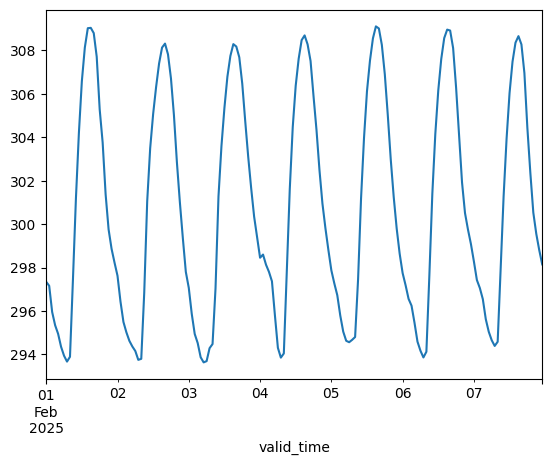

In [5]:
single_point_df = data_array.isel(latitude=0, longitude=0).to_dataframe()
single_point_df['t2m'].plot()

A common way to aggregate hourly to daily temperature values is to take the average temperature for each day. We can do so easily by extracting the `t2m` variable and passing that to the `temporal.daily_reduce` function from the `earthkit.transforms` module. We specify that we want the average temperature value by setting `how='mean'`: 

In [8]:
temp = data_array['t2m']
daily_temp = transforms.temporal.daily_reduce(temp, how='mean')

If we select the first grid point from the aggregated data and display it as a dataframe, we see that this grid point now contains exactly 7 days of aggregated temperature values:

In [9]:
daily_temp.isel(latitude=0, longitude=0).to_dataframe()

,number,latitude,longitude,t2m
valid_time,,,,
2025-02-01,0,9.918,-13.304,300.664093
2025-02-02,0,9.918,-13.304,300.516602
2025-02-03,0,9.918,-13.304,300.582581
2025-02-04,0,9.918,-13.304,301.307281
2025-02-05,0,9.918,-13.304,301.129486
2025-02-06,0,9.918,-13.304,300.957947
2025-02-07,0,9.918,-13.304,300.681122


### Precipitation

For the precipitation data, let's do the same as we did for temperature and plot what the hourly precipitation data looks like for a single grid point. We see from this that the precipitation data contain very small values reported in meters, and that each hourly observation indicates how much rain occurred during that hour. The amount of rain varies at different times throughout the week: 

<Axes: xlabel='valid_time'>

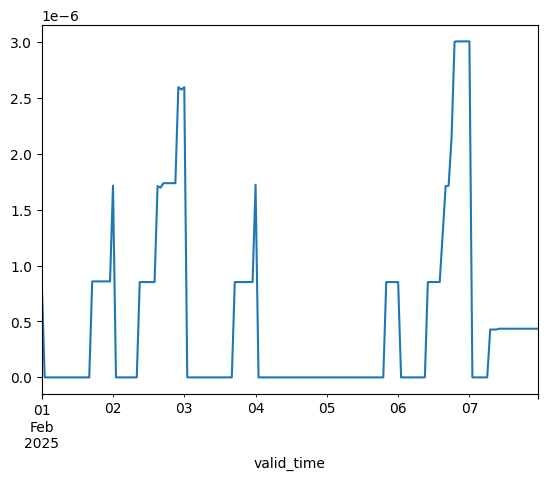

In [10]:
single_point_df['tp'].plot()

The typical way to aggregate hourly to daily precipiation, is to calculate the sum total of all the precipitation that happened throughout each day. We can do so by extracting the `tp` variable and again passing that to `earthkit`'s `temporal.daily_reduce` function. This time we want to compute the sum of hourly precipitation values, so we set `how='sum'`: 

In [11]:
precip = data_array['tp']
daily_precip = transforms.temporal.daily_reduce(precip, how='sum')

Finally, let's select the first grid point from the aggregated data and display it as a dataframe. We again see that this grid point contains 7 days of aggregated precipitation values:

In [13]:
daily_precip.isel(latitude=0, longitude=0).to_dataframe()

,number,latitude,longitude,tp
valid_time,,,,
2025-02-01,0,9.918,-13.304,0.000007
2025-02-02,0,9.918,-13.304,0.000024
2025-02-03,0,9.918,-13.304,0.000009
2025-02-04,0,9.918,-13.304,0.000002
2025-02-05,0,9.918,-13.304,0.000003
2025-02-06,0,9.918,-13.304,0.000027
2025-02-07,0,9.918,-13.304,0.000010


## Aggregating daily climate data to monthly

Let's consider now that we already have daily climate data, such as the [ERA5 daily post-processed statistics](https://cds.climate.copernicus.eu/datasets/derived-era5-pressure-levels-daily-statistics?tab=overview), and want instead to aggregate these to monthly. 

We'll start by loading a NetCDF file containing daily ERA5 temperature data for the entire month of July 2025: 

In [15]:
data = earthkit.data.from_source('file', '../data/era5-daily-temp-precip-july-2025-sierra-leone.nc')
data_array = data.to_xarray()

Let's plot the daily temperature values for a single grid point: 

<Axes: xlabel='valid_time'>

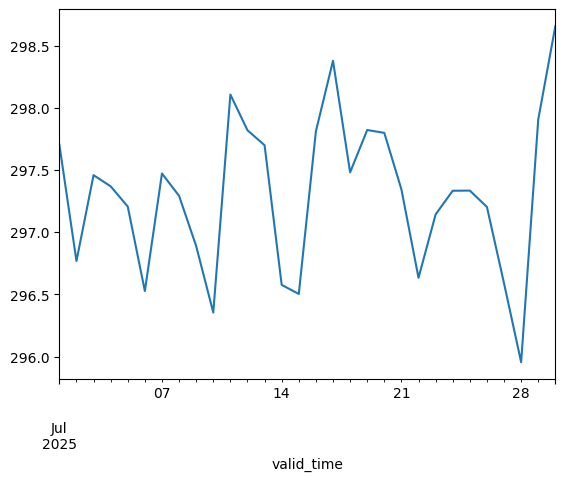

In [16]:
single_point_df = data_array.isel(latitude=0, longitude=0).to_dataframe()
single_point_df['t2m'].plot()

To aggregate the daily temperature data to monthly, we use `earthkit`'s `temporal.monthly_reduce` function:

In [17]:
temp = data_array['t2m']
monthly_temp = transforms.temporal.monthly_reduce(temp, how='mean')

Finally, we display the aggregated dataframe for a single grid point, showing that we are left with only one monthly aggregated value per grid point (i.e. the month of July):

In [20]:
monthly_temp.isel(latitude=0, longitude=0).to_dataframe()

,number,latitude,longitude,t2m
valid_time,,,,
2025-07-01,0,9.918,-13.304,297.304779


## Next steps

In this notebook we have shown how to aggregate hourly climate data to daily data so that it can be imported into DHIS2. We have also shown how to inspect the temporal aspects of the hourly data, and how aggregation differs for temperature and precipitation variables. We also briefly showed how the same principles can be applied to aggregate daily climate data to monthly. 

Once your gridded climate data has been aggregated to the desired time period, the next step is to spatially aggregate from gridded data to DHIS2 organisation units. See our guide for [aggregating to DHIS2 organisation units](org-unit-aggregation.ipynb). 